In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sudeeshmuthum","key":"1eac2ce73f26d9866670a76863a6a79f"}'}

In [ ]:
# Move the API token to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions for the API token
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d trolukovich/food11-image-dataset

100% 1.08G/1.08G [00:13<00:00, 86.1MB/s]
100% 1.08G/1.08G [00:13<00:00, 84.8MB/s]


In [ ]:
!unzip food11-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: training/Soup/223.jpg   
  inflating: training/Soup/224.jpg   
  inflating: training/Soup/225.jpg   
  inflating: training/Soup/226.jpg   
  inflating: training/Soup/227.jpg   
  inflating: training/Soup/228.jpg   
  inflating: training/Soup/229.jpg   
  inflating: training/Soup/23.jpg    
  inflating: training/Soup/230.jpg   
  inflating: training/Soup/231.jpg   
  inflating: training/Soup/232.jpg   
  inflating: training/Soup/233.jpg   
  inflating: training/Soup/234.jpg   
  inflating: training/Soup/235.jpg   
  inflating: training/Soup/236.jpg   
  inflating: training/Soup/237.jpg   
  inflating: training/Soup/238.jpg   
  inflating: training/Soup/239.jpg   
  inflating: training/Soup/24.jpg    
  inflating: training/Soup/240.jpg   
  inflating: training/Soup/241.jpg   
  inflating: training/Soup/242.jpg   
  inflating: training/Soup/243.jpg   
  inflating: training/Soup/244.jpg   
  inflating: training/Soup/245.jpg   

In [ ]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import random
import cv2
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import tensorflow_hub as hub
import tensorflow as tf
import pathlib

In [ ]:
model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model.trainable = False

In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D()(model.output)

In [ ]:
output = tf.keras.layers.Dense(11, activation='softmax')(x)

In [ ]:
model = tf.keras.Model(inputs=model.input, outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=20,
width_shift_range=0.2,
height_shift_range=0.2,
horizontal_flip=False,
fill_mode='nearest'
)

In [ ]:
train_generator = datagen.flow_from_directory(
'/content/training',
target_size=(224, 224),
batch_size=32,
class_mode='categorical',
shuffle=True
)

# Create a validation generator from the validation folder
validation_generator = datagen.flow_from_directory(
'/content/validation',
target_size=(224, 224),
batch_size=32,
class_mode='categorical',
shuffle=False
)

# Create a evaluation generator from the evaluation folder
evaluation_generator = datagen.flow_from_directory(
'/content/evaluation',
target_size=(224, 224),
batch_size=32,
class_mode='categorical',
shuffle=False
)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


total training image count = 9866 

-------------------------------------
Class name =  Bread
count      =  994
proportion =  0.10075005067909994
-------------------------------------
Class name =  Dairy product
count      =  429
proportion =  0.0434826677478208
-------------------------------------
Class name =  Dessert
count      =  1500
proportion =  0.15203729981755523
-------------------------------------
Class name =  Egg
count      =  986
proportion =  0.09993918508007298
-------------------------------------
Class name =  Fried food
count      =  848
proportion =  0.0859517534968579
-------------------------------------
Class name =  Meat
count      =  1325
proportion =  0.13429961483884045
-------------------------------------
Class name =  Noodles-Pasta
count      =  440
proportion =  0.04459760794648287
-------------------------------------
Class name =  Rice
count      =  280
proportion =  0.028380295965943644
-------------------------------------
Class name =  Seafood
coun

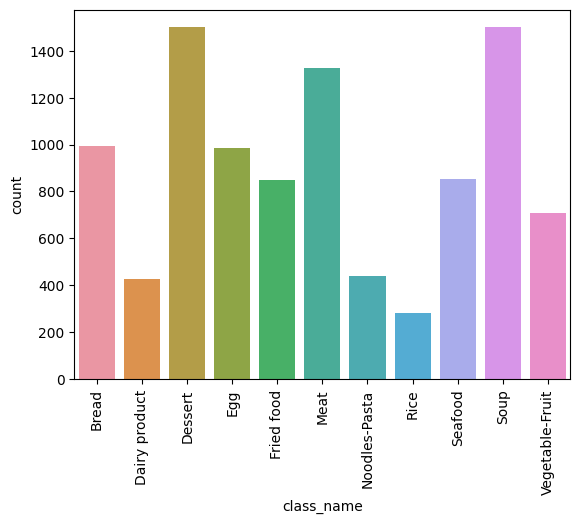

In [ ]:
num_classes = 11
class_names = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']
total = 0
data_dir_train = pathlib.Path("/content/training")
all_count = []
class_name = []
count = []
for i in range(num_classes):
  count.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))
  total += count[i]
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  countnew = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",countnew)
  print("proportion = ",countnew/total)
  print("-------------------------------------")
  all_count.append(countnew)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

In [ ]:
count

[994, 429, 1500, 986, 848, 1325, 440, 280, 855, 1500, 709]

In [ ]:
!pip install Augmentor


In [ ]:
import Augmentor

path_to_training_dataset = '/content/training'
output_directory = '/content/augmented_data/'
os.makedirs(output_directory, exist_ok=True)
i =0
for class_name in class_names:
    class_path = os.path.join(path_to_training_dataset, class_name)
    p = Augmentor.Pipeline(class_path, output_directory=os.path.join(output_directory, class_name))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(2000)

Initialised with 994 image(s) found.
Output directory set to /content/augmented_data/Bread.

Processing <PIL.Image.Image image mode=RGB size=512x289 at 0x7E1A7C8027A0>: 100%|██████████| 2000/2000 [01:05<00:00, 30.76 Samples/s]


Initialised with 429 image(s) found.
Output directory set to /content/augmented_data/Dairy product.

Processing <PIL.Image.Image image mode=RGB size=512x512 at 0x7E19D433B010>: 100%|██████████| 2000/2000 [02:08<00:00, 15.51 Samples/s]


Initialised with 1500 image(s) found.
Output directory set to /content/augmented_data/Dessert.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=382x512 at 0x7E19D5D1BF70>: 100%|██████████| 2000/2000 [01:01<00:00, 32.36 Samples/s]


Initialised with 986 image(s) found.
Output directory set to /content/augmented_data/Egg.

Processing <PIL.Image.Image image mode=RGB size=512x512 at 0x7E19D6D23730>: 100%|██████████| 2000/2000 [01:02<00:00, 32.23 Samples/s]


Initialised with 848 image(s) found.
Output directory set to /content/augmented_data/Fried food.

Processing <PIL.Image.Image image mode=RGB size=512x341 at 0x7E19D6D271C0>: 100%|██████████| 2000/2000 [00:59<00:00, 33.68 Samples/s]


Initialised with 1325 image(s) found.
Output directory set to /content/augmented_data/Meat.

Processing <PIL.Image.Image image mode=RGB size=512x512 at 0x7E19D6D24670>: 100%|██████████| 2000/2000 [01:02<00:00, 31.78 Samples/s]


Initialised with 440 image(s) found.
Output directory set to /content/augmented_data/Noodles-Pasta.

Processing <PIL.Image.Image image mode=RGB size=512x512 at 0x7E19D6E961D0>: 100%|██████████| 2000/2000 [01:01<00:00, 32.39 Samples/s]


Initialised with 280 image(s) found.
Output directory set to /content/augmented_data/Rice.

Processing <PIL.Image.Image image mode=RGB size=382x512 at 0x7E1A8BD4B910>: 100%|██████████| 2000/2000 [00:55<00:00, 35.83 Samples/s]


Initialised with 855 image(s) found.
Output directory set to /content/augmented_data/Seafood.

Processing <PIL.Image.Image image mode=RGB size=382x512 at 0x7E19D5CD6050>: 100%|██████████| 2000/2000 [01:05<00:00, 30.71 Samples/s]


Initialised with 1500 image(s) found.
Output directory set to /content/augmented_data/Soup.

Processing <PIL.Image.Image image mode=RGB size=512x512 at 0x7E1A8BD4B910>: 100%|██████████| 2000/2000 [00:59<00:00, 33.44 Samples/s]


Initialised with 709 image(s) found.
Output directory set to /content/augmented_data/Vegetable-Fruit.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E19C8777B80>: 100%|██████████| 2000/2000 [02:32<00:00, 13.15 Samples/s]


In [ ]:
#folder_to_remove = '/content/augmented_data'
#!rm -r "$folder_to_remove"

In [ ]:
import os

directory_path = '/content/augmented_data'

image_extensions = ['.jpg', '.jpeg', '.png']
total_images = 0
for dirpath, dirnames, filenames in os.walk(directory_path):
    for filename in filenames:
        if any(filename.endswith(ext) for ext in image_extensions):
            total_images += 1
print(f'Number of images in the directory: {total_images}')

Number of images in the directory: 22000


In [ ]:
datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=20,
width_shift_range=0.2,
height_shift_range=0.2,
horizontal_flip=False,
fill_mode='nearest',
validation_split = 0.2
)

In [ ]:
train_generator = datagen.flow_from_directory(
'/content/augmented_data',
target_size=(224, 224),
batch_size=32,
class_mode='categorical',
subset = 'training',
shuffle=True
)

validation_generator = datagen.flow_from_directory(
'/content/augmented_data',
target_size=(224, 224),
batch_size=32,
class_mode='categorical',
subset = 'validation',
shuffle=False
)

evaluation_generator = datagen.flow_from_directory(
'/content/evaluation',
target_size=(224, 224),
batch_size=32,
class_mode='categorical',
shuffle=False
)

Found 17600 images belonging to 11 classes.
Found 4400 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


In [ ]:
y_pred = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
550/550 [==============================] - 1188s 2s/step - loss: 0.7957 - accuracy: 0.7398 - val_loss: 0.6686 - val_accuracy: 0.7773
Epoch 2/5
550/550 [==============================] - 1203s 2s/step - loss: 0.5080 - accuracy: 0.8330 - val_loss: 0.6335 - val_accuracy: 0.7909
Epoch 3/5
550/550 [==============================] - 1201s 2s/step - loss: 0.4420 - accuracy: 0.8553 - val_loss: 0.6094 - val_accuracy: 0.7941
Epoch 4/5
550/550 [==============================] - 1180s 2s/step - loss: 0.4034 - accuracy: 0.8672 - val_loss: 0.6421 - val_accuracy: 0.7911
Epoch 5/5
550/550 [==============================] - 1148s 2s/step - loss: 0.3693 - accuracy: 0.8767 - val_loss: 0.6152 - val_accuracy: 0.8011


In [ ]:
prediction = model.predict(evaluation_generator)

105/105 [==============================] - 171s 2s/step


In [ ]:
y_pred_classes = np.argmax(prediction, axis=1)

In [ ]:
model.save('Food_classification_model_smol.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
